In [3]:
import numpy as np
import pandas as pd

# Indodax Data Retrieval

In [1]:
import requests
import datetime
import pytz
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

In [176]:
root_uri_trade_api = 'https://indodax.com/api'
root_uri_chart_api = 'https://indodax.com/tradingview/history'
#?symbol=BTCIDR&resolution=15&from=1546489788&to=1547785848'
chart_currency = 'BTCIDR'
period = 'D'
time_begin = int(datetime.datetime(2017, 1, 1).timestamp())
time_end = int(datetime.datetime(2017, 12, 5).timestamp())
# 2017 1 1 - 2017 6 1
chart_query = '?symbol={}&resolution={}&from={}&to={}'.format(chart_currency, period, time_begin, time_end)

r = requests.get(root_uri_chart_api + chart_query)
price = pd.DataFrame({
    'open': r.json()['o'],
    'close': r.json()['c'],
    'high': r.json()['h'],
    'low': r.json()['l'],
    'volume': r.json()['v']
# }, index=list(map(lambda t: (datetime.datetime.utcfromtimestamp(t) + datetime.timedelta(hours=7)).strftime('%d/%m %H.%M'), r.json()['t'])))
}, index=list(map(lambda t: (datetime.datetime.utcfromtimestamp(t) + datetime.timedelta(hours=7)), r.json()['t'])))
len(price)

338

# OHLC Chart

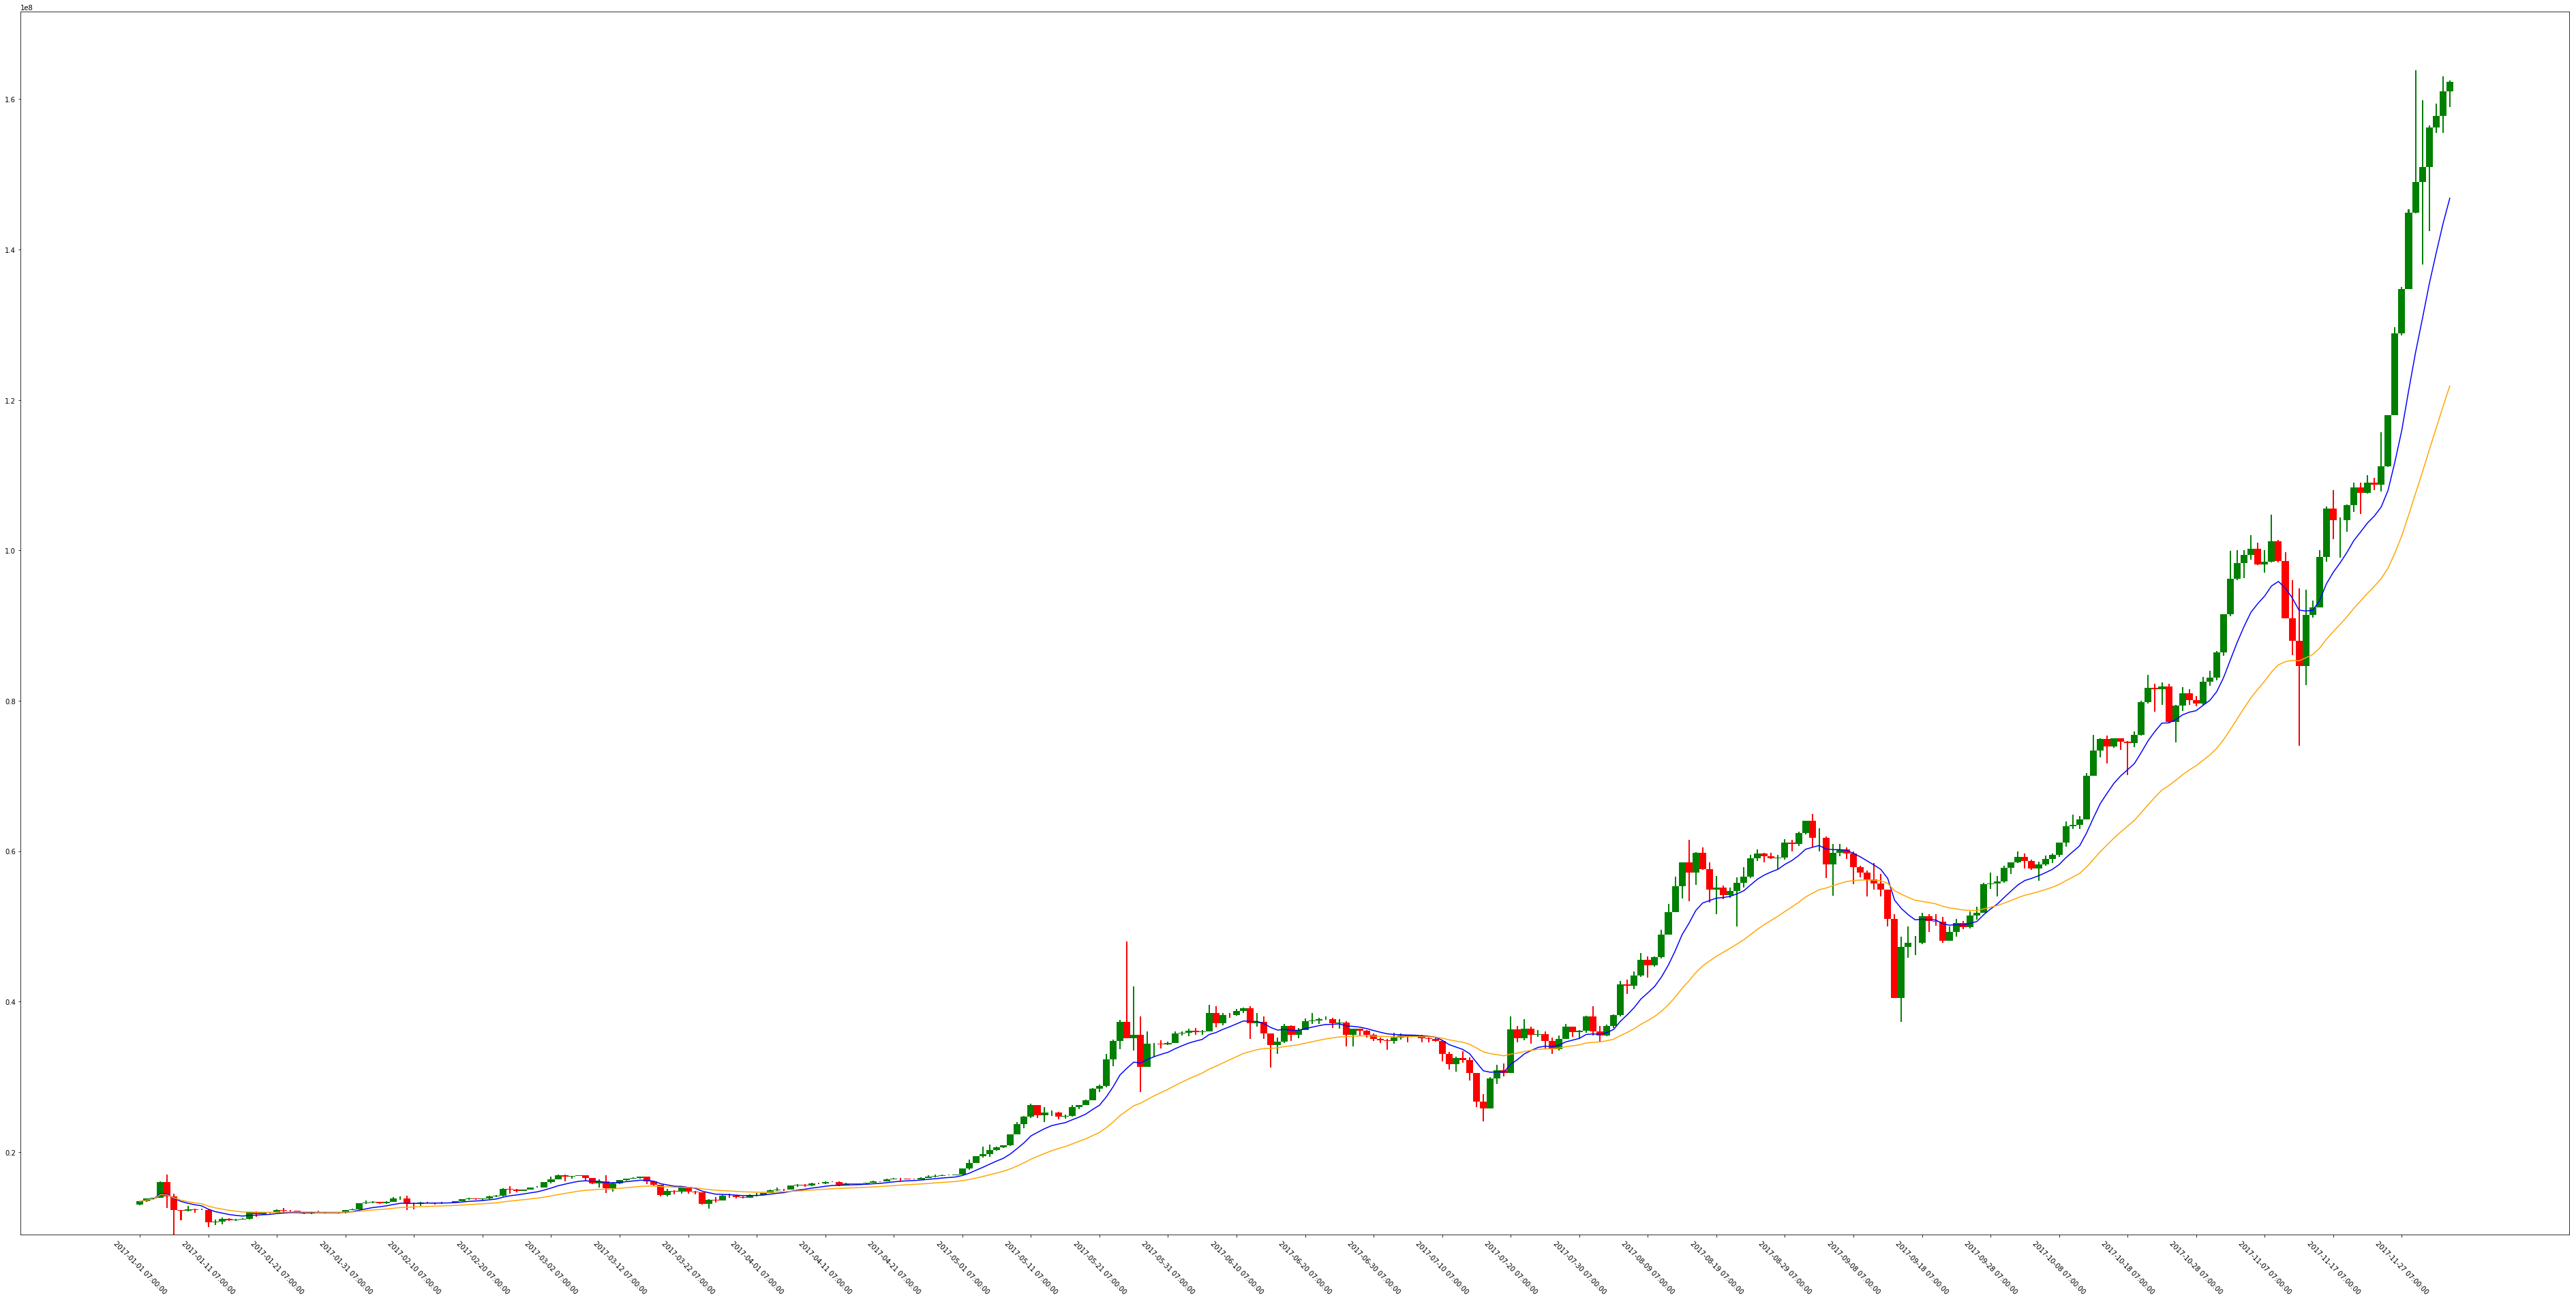

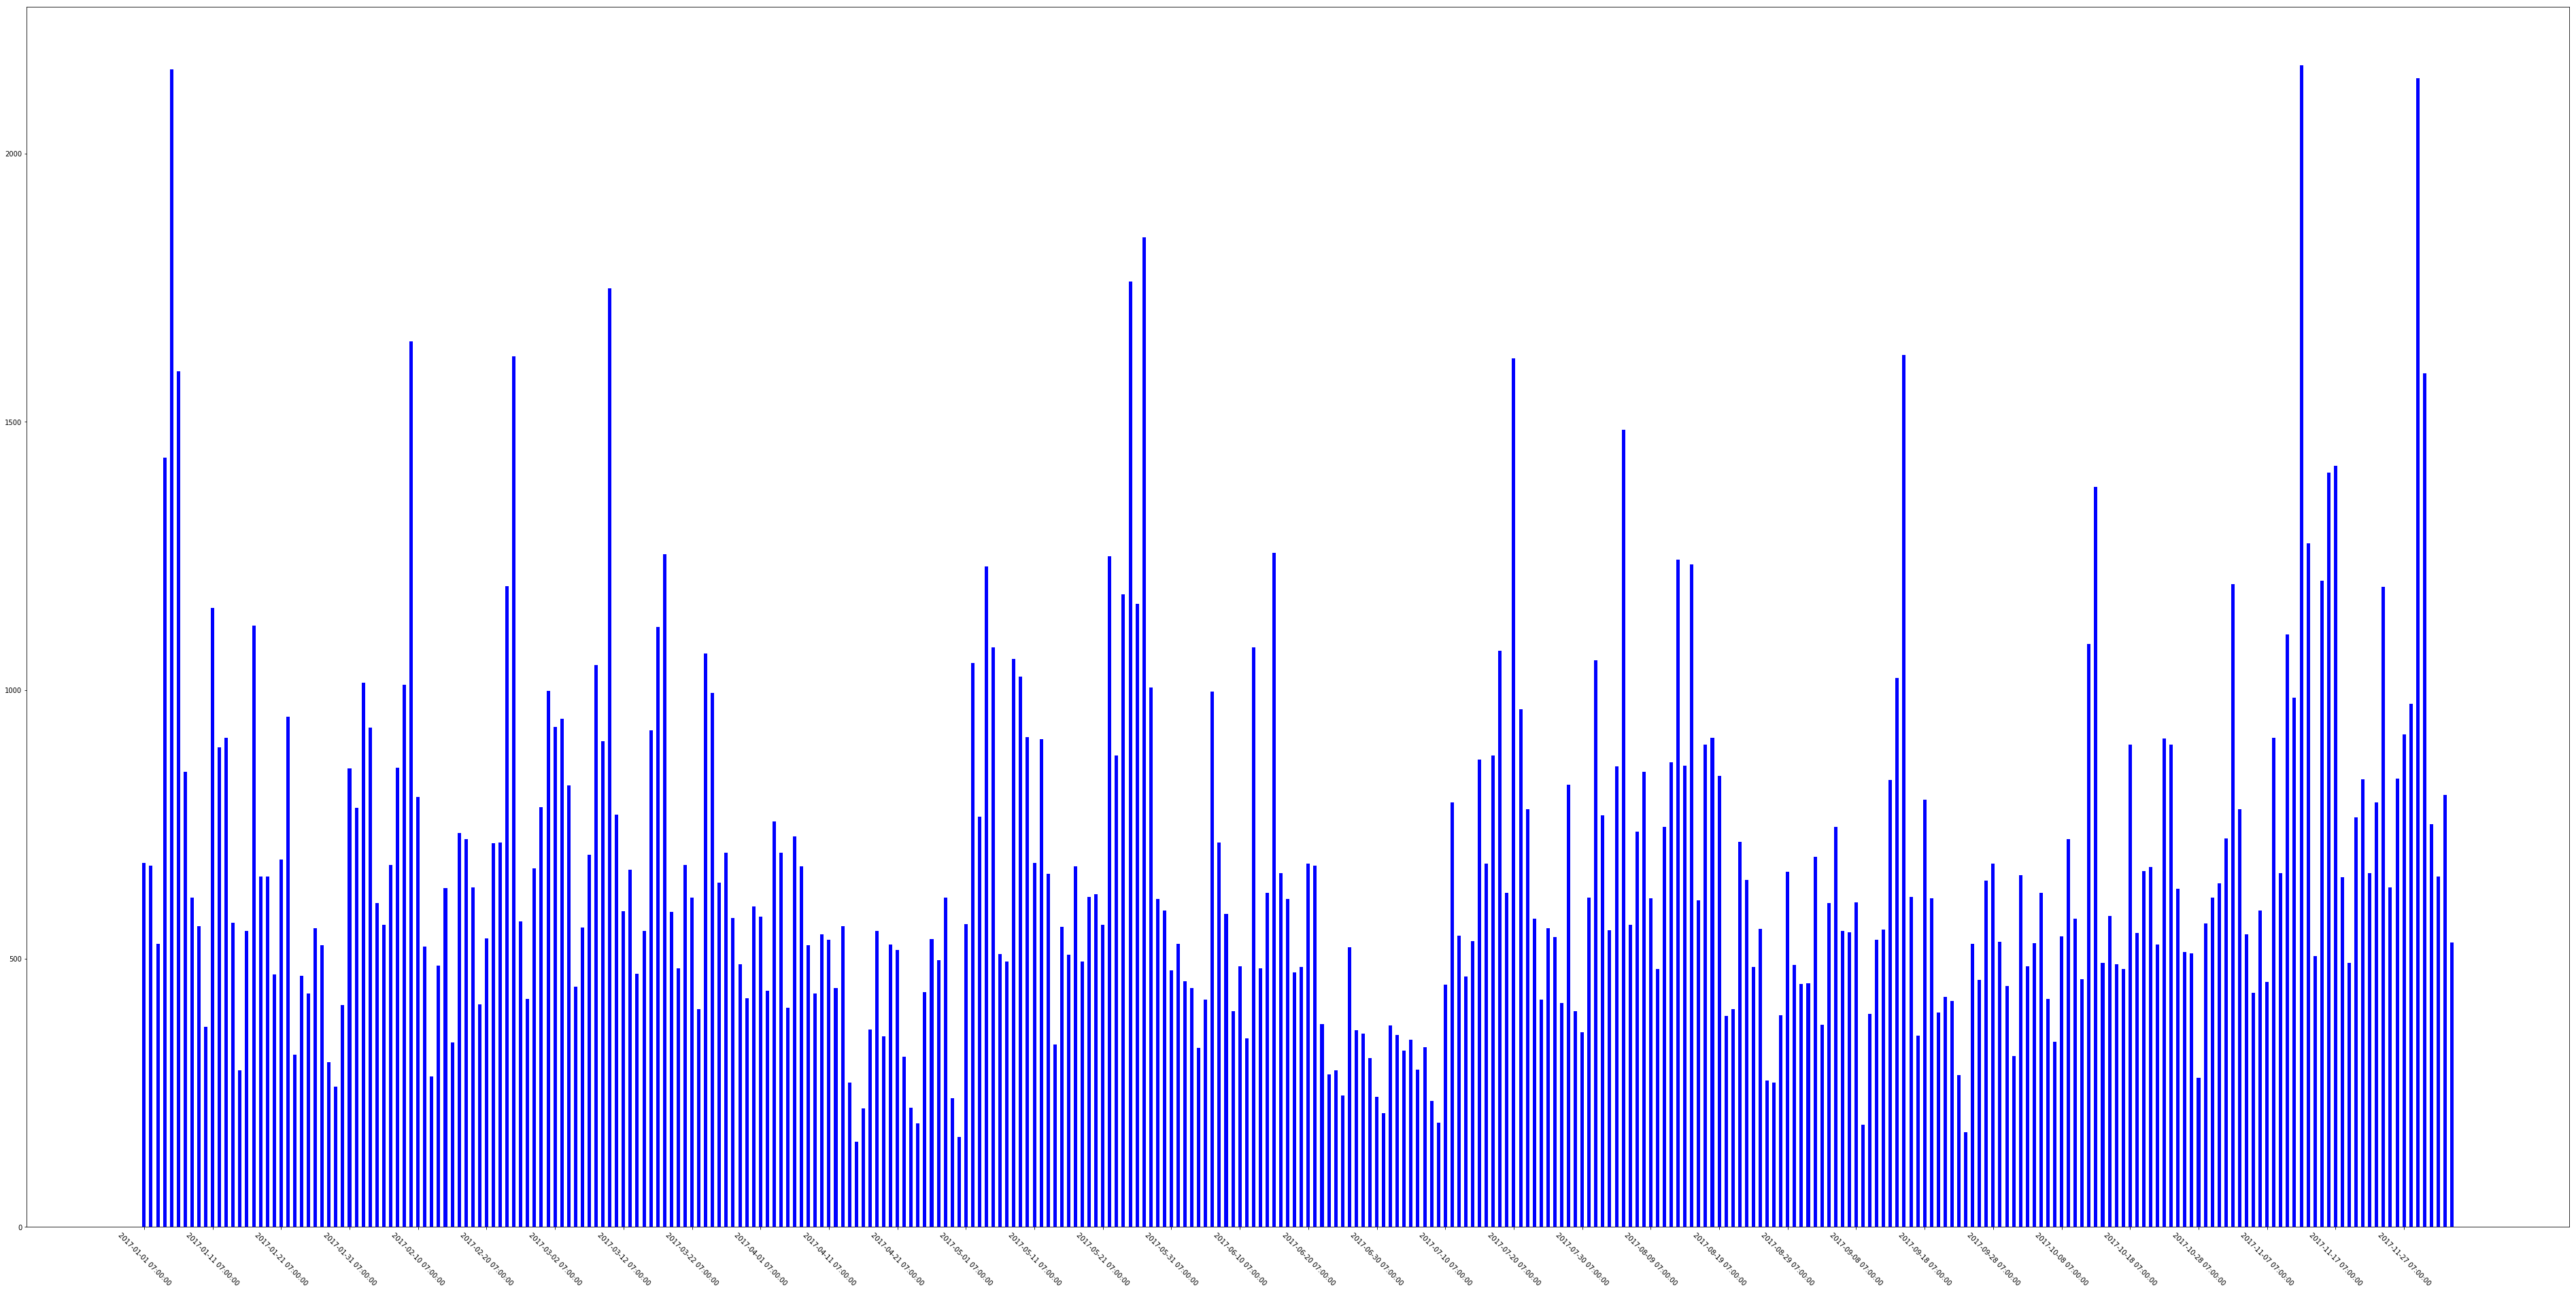

In [177]:
%matplotlib qt
candle_color = lambda o, c: 'g' if c >= o else 'r'
fig_w = len(price.open)//5
fig_h = fig_w // 2
plt.figure(figsize=(fig_w, fig_h))
plt.bar( [i for i in range(len(price.open))],
        [abs(c-o) for c,o in zip(price.close, price.open)],
        [1 for i in range(len(price.open))],
        [min(c, o) for c,o in zip(price.close, price.open)],
        color=[candle_color(o, c) for c,o in zip(price.close, price.open)]
)
plt.bar( [i for i in range(len(price.high))],
        [h-l for h,l in zip(price.high, price.low)],
        [.2 for i in range(len(price.high))],
        [l for l in price.low],
        color=[candle_color(o, c) for c,o in zip(price.close, price.open)]
)
plt.plot([i for i in range(len(price.high))], price.close.ewm(span=10).mean(), color='blue')
plt.plot([i for i in range(len(price.high))], price.close.ewm(span=30).mean(), color='orange')
ax = plt.gca()
ax.set_xticks([i for i in range(len(price.index))][::10])
ax.set_xticklabels(price.index[::10], rotation=-45)
plt.figure(figsize=(fig_w, fig_h))
plt.bar([i for i in range(len(price.volume))],
        price.volume,
        .5,
        color='blue'
)
ax = plt.gca()
ax.set_xticks([i for i in range(len(price.index))][::10])
ax.set_xticklabels(price.index[::10], rotation=-45)

#use this to visualize
plt.show()

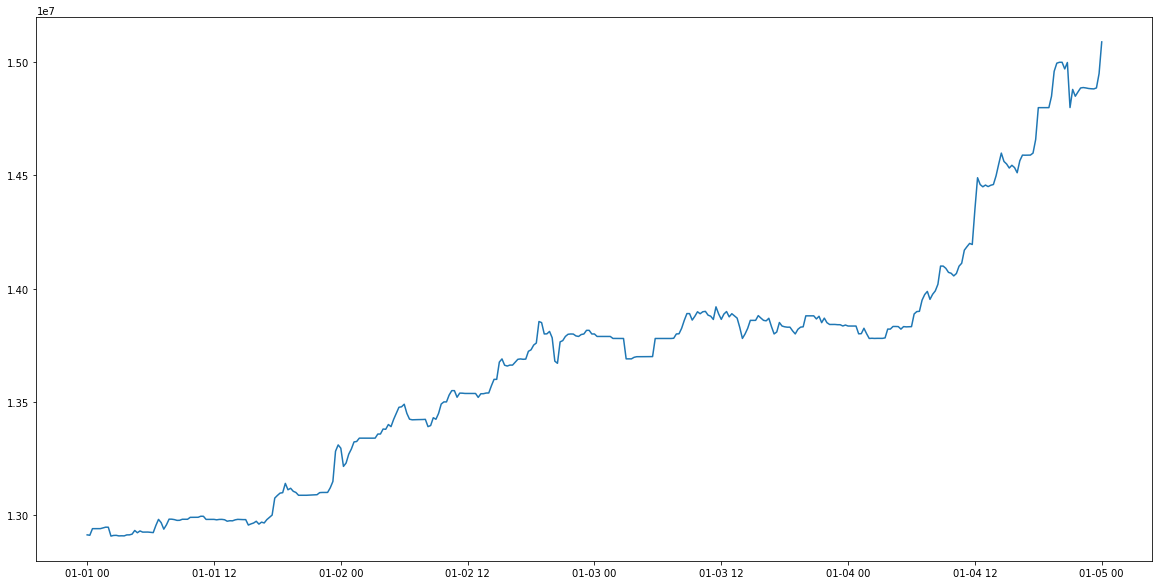

In [171]:
plt.figure(figsize=(20,10))
plt.plot(price.close)

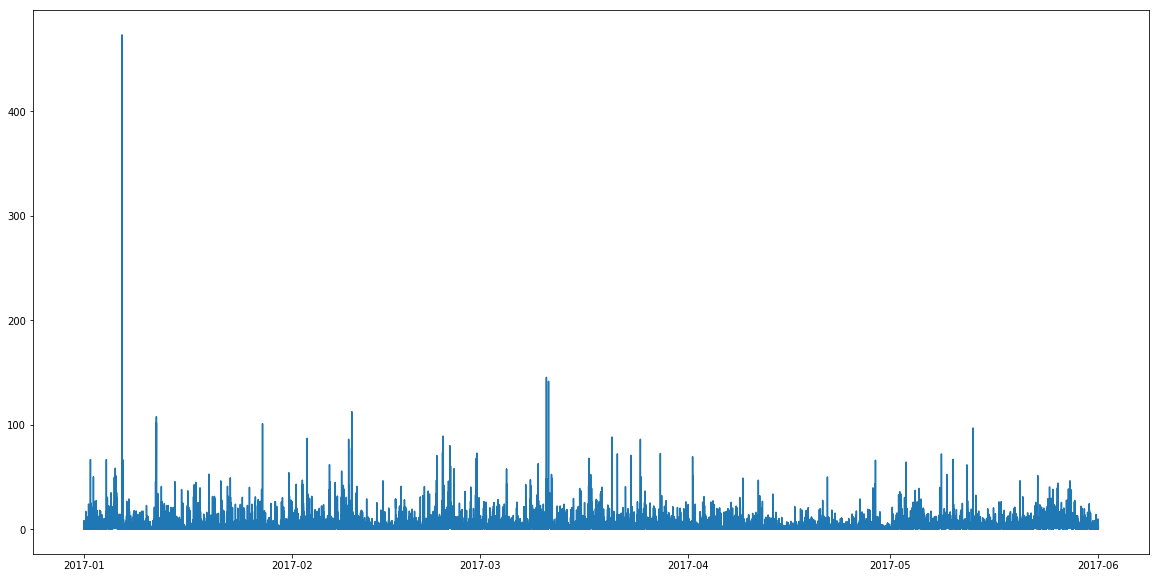

In [10]:
plt.figure(figsize=(20,10))
plt.plot(price.volume)

# Labeling
Buy Hold Sell

In [163]:
BUY = -1
HOLD = 0
SELL = 1

In [12]:
close = np.array(price.close)
label = [0 for i in range(len(close))]
t_forward = 10
commission = 0.003
min_net_profit = lambda p: p * (1+(2*commission))
for i in range(t_forward, len(price)):
    # sample the future
    sample = np.array([close[i-j] for j in range(5)])
    if (sample > min_net_profit(close[i-t_forward])).sum() > 4:
        label[i-t_forward] = -1
        label[i] = 1

In [13]:
print('buy', len(list(filter(lambda p: p == -1, label))))
print('hold', len(list(filter(lambda p: p == 0, label))))
print('sell', len(list(filter(lambda p: p == 1, label))))

buy 2043
hold 39617
sell 1829


### Enter market or not and when to exit

In [154]:
%matplotlib qt

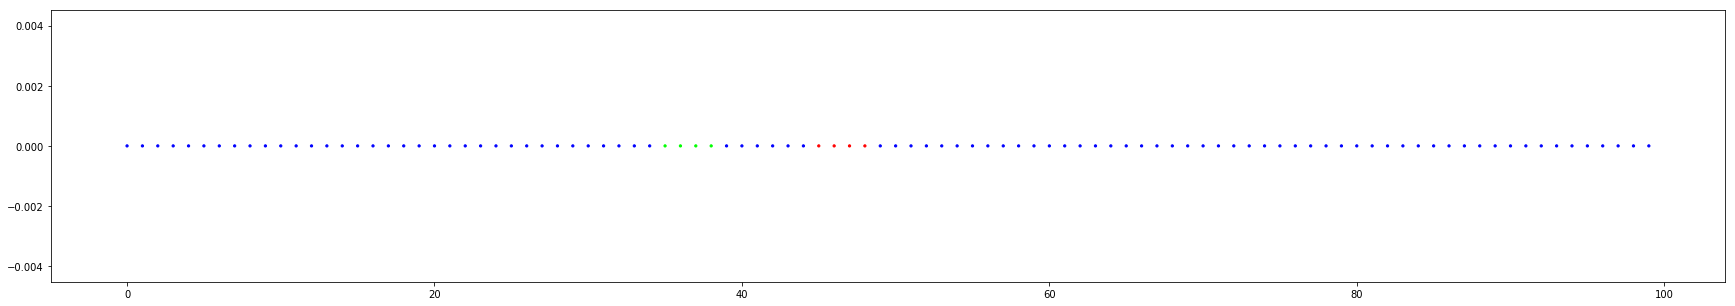

In [162]:
start = 500
end = 600
plt.figure(figsize=(30, 5))
plt.scatter(
    [i for i in range((end-start))],
    [0 for i in range((end-start))],
    color=[(1 if i == 1 else 0, 1 if i == -1 else 0, 1 if i == 0 else 0) for i in label[start:end]],
    s=5
)

In [ ]:
OUT = 0
IN = 1
market_in_features = [] # (prices, volumes)
market_in_labels = [] # how long to hold
label_entrance = [0 for i in range(len(close))]
state = OUT
play = []
close = price.close
volume = price.volume
for i in range(len(label)):
    if state == OUT and label[i] == BUY:
        state = IN
        label_entrance[i] = IN
        play.append([close[i], volume[i]])
    if state == 
        

In [22]:
action_frame = pd.DataFrame(label).set_index(price.index).join(price)
action_frame.columns = ['low', 'open', 'close', 'high', 'real_low', 'volume']

# Backtrading

In [24]:
import backtrader as bt
import backtrader.feeds as btfeeds

In [25]:
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # weird workaround due to limitation to column name
        # we take the low column as action
        self.data_action = self.datas[0].low
        # To keep track of pending orders
        self.order = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
                self.opsize = order.executed.size
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

                gross_pnl = (order.executed.price - self.buyprice) * \
                    self.opsize

                net_pnl = gross_pnl - self.buycomm - order.executed.comm
                self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                         (gross_pnl, net_pnl))


            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def next(self):
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # buy!
            if self.data_action[0] == -1:
                self.log('BUY CREATE')
                self.order = self.buy()

        else:
            # sell!
            if self.data_action[0] == 1:
                self.log('SELL CREATE')
                self.order = self.sell()

## Execute

In [26]:
# data_feed = btfeeds.PandasData(dataname=price, openinterest=None)
data_feed = btfeeds.PandasData(dataname=action_frame, openinterest=None)
#print(data_feed)

cerebro = bt.Cerebro()
cerebro.addstrategy(TestStrategy)
cerebro.adddata(data_feed)
# cerebro.adddata(action_frame)
cerebro.broker.setcash(100000000.0)
cerebro.broker.setcommission(commission=commission)

# Print out the starting conditions
startingPortofolio = cerebro.broker.getvalue()
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
cerebro.run()

# Print out the final result
finalPortofolio = cerebro.broker.getvalue()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
print('Profit: %.2f (%.6f%%)' % (finalPortofolio - startingPortofolio, (finalPortofolio - startingPortofolio)/startingPortofolio*100))

Starting Portfolio Value: 100000000.00
2017-01-01, BUY CREATE
2017-01-01, BUY EXECUTED, Price: 12990000.00, Cost: 12990000.00, Comm 38970.00
2017-01-01, SELL CREATE
2017-01-01, SELL EXECUTED, Price: 13086600.00, Cost: 12990000.00, Comm 39259.80
2017-01-01, OPERATION PROFIT, GROSS 96600.00, NET 18370.20
2017-01-01, BUY CREATE
2017-01-01, BUY EXECUTED, Price: 13120400.00, Cost: 13120400.00, Comm 39361.20
2017-01-02, SELL CREATE
2017-01-02, SELL EXECUTED, Price: 13250000.00, Cost: 13120400.00, Comm 39750.00
2017-01-02, OPERATION PROFIT, GROSS 129600.00, NET 50488.80
2017-01-02, BUY CREATE
2017-01-02, BUY EXECUTED, Price: 13177800.00, Cost: 13177800.00, Comm 39533.40
2017-01-02, SELL CREATE
2017-01-02, SELL EXECUTED, Price: 13299600.00, Cost: 13177800.00, Comm 39898.80
2017-01-02, OPERATION PROFIT, GROSS 121800.00, NET 42367.80
2017-01-02, BUY CREATE
2017-01-02, BUY EXECUTED, Price: 13670100.00, Cost: 13670100.00, Comm 41010.30
2017-01-02, SELL CREATE
2017-01-02, SELL EXECUTED, Price: 1378

2017-01-10, BUY CREATE
2017-01-10, BUY EXECUTED, Price: 12278200.00, Cost: 12278200.00, Comm 36834.60
2017-01-10, SELL CREATE
2017-01-10, SELL EXECUTED, Price: 12352000.00, Cost: 12278200.00, Comm 37056.00
2017-01-10, OPERATION PROFIT, GROSS 73800.00, NET -90.60
2017-01-11, BUY CREATE
2017-01-11, BUY EXECUTED, Price: 11508100.00, Cost: 11508100.00, Comm 34524.30
2017-01-11, SELL CREATE
2017-01-11, SELL EXECUTED, Price: 11820000.00, Cost: 11508100.00, Comm 35460.00
2017-01-11, OPERATION PROFIT, GROSS 311900.00, NET 241915.70
2017-01-11, BUY CREATE
2017-01-11, BUY EXECUTED, Price: 10579900.00, Cost: 10579900.00, Comm 31739.70
2017-01-11, SELL CREATE
2017-01-11, SELL EXECUTED, Price: 11220000.00, Cost: 10579900.00, Comm 33660.00
2017-01-11, OPERATION PROFIT, GROSS 640100.00, NET 574700.30
2017-01-12, BUY CREATE
2017-01-12, BUY EXECUTED, Price: 10209000.00, Cost: 10209000.00, Comm 30627.00
2017-01-12, SELL CREATE
2017-01-12, SELL EXECUTED, Price: 10497000.00, Cost: 10209000.00, Comm 31491.

2017-01-22, BUY CREATE
2017-01-22, BUY EXECUTED, Price: 12396500.00, Cost: 12396500.00, Comm 37189.50
2017-01-22, SELL CREATE
2017-01-22, SELL EXECUTED, Price: 12500000.00, Cost: 12396500.00, Comm 37500.00
2017-01-22, OPERATION PROFIT, GROSS 103500.00, NET 28810.50
2017-01-22, BUY CREATE
2017-01-22, BUY EXECUTED, Price: 12015000.00, Cost: 12015000.00, Comm 36045.00
2017-01-22, SELL CREATE
2017-01-22, SELL EXECUTED, Price: 12100100.00, Cost: 12015000.00, Comm 36300.30
2017-01-22, OPERATION PROFIT, GROSS 85100.00, NET 12754.70
2017-01-22, BUY CREATE
2017-01-22, BUY EXECUTED, Price: 11900300.00, Cost: 11900300.00, Comm 35700.90
2017-01-22, SELL CREATE
2017-01-22, SELL EXECUTED, Price: 12151100.00, Cost: 11900300.00, Comm 36453.30
2017-01-22, OPERATION PROFIT, GROSS 250800.00, NET 178645.80
2017-01-22, BUY CREATE
2017-01-22, BUY EXECUTED, Price: 12052700.00, Cost: 12052700.00, Comm 36158.10
2017-01-22, SELL CREATE
2017-01-22, SELL EXECUTED, Price: 12169000.00, Cost: 12052700.00, Comm 36507

2017-02-11, BUY CREATE
2017-02-11, BUY EXECUTED, Price: 12821600.00, Cost: 12821600.00, Comm 38464.80
2017-02-11, SELL CREATE
2017-02-11, SELL EXECUTED, Price: 12976600.00, Cost: 12821600.00, Comm 38929.80
2017-02-11, OPERATION PROFIT, GROSS 155000.00, NET 77605.40
2017-02-11, BUY CREATE
2017-02-11, BUY EXECUTED, Price: 12838100.00, Cost: 12838100.00, Comm 38514.30
2017-02-11, SELL CREATE
2017-02-11, SELL EXECUTED, Price: 13069900.00, Cost: 12838100.00, Comm 39209.70
2017-02-11, OPERATION PROFIT, GROSS 231800.00, NET 154076.00
2017-02-11, BUY CREATE
2017-02-11, BUY EXECUTED, Price: 13038500.00, Cost: 13038500.00, Comm 39115.50
2017-02-11, SELL CREATE
2017-02-11, SELL EXECUTED, Price: 13199700.00, Cost: 13038500.00, Comm 39599.10
2017-02-11, OPERATION PROFIT, GROSS 161200.00, NET 82485.40
2017-02-11, BUY CREATE
2017-02-11, BUY EXECUTED, Price: 13266700.00, Cost: 13266700.00, Comm 39800.10
2017-02-11, SELL CREATE
2017-02-11, SELL EXECUTED, Price: 13350100.00, Cost: 13266700.00, Comm 4005

2017-03-07, BUY CREATE
2017-03-07, BUY EXECUTED, Price: 16308100.00, Cost: 16308100.00, Comm 48924.30
2017-03-07, SELL CREATE
2017-03-07, SELL EXECUTED, Price: 16520200.00, Cost: 16308100.00, Comm 49560.60
2017-03-07, OPERATION PROFIT, GROSS 212100.00, NET 113615.10
2017-03-08, BUY CREATE
2017-03-08, BUY EXECUTED, Price: 15800100.00, Cost: 15800100.00, Comm 47400.30
2017-03-08, SELL CREATE
2017-03-08, SELL EXECUTED, Price: 15965000.00, Cost: 15800100.00, Comm 47895.00
2017-03-08, OPERATION PROFIT, GROSS 164900.00, NET 69604.70
2017-03-08, BUY CREATE
2017-03-08, BUY EXECUTED, Price: 15900200.00, Cost: 15900200.00, Comm 47700.60
2017-03-08, SELL CREATE
2017-03-08, SELL EXECUTED, Price: 16230100.00, Cost: 15900200.00, Comm 48690.30
2017-03-08, OPERATION PROFIT, GROSS 329900.00, NET 233509.10
2017-03-08, BUY CREATE
2017-03-08, BUY EXECUTED, Price: 16222500.00, Cost: 16222500.00, Comm 48667.50
2017-03-08, SELL CREATE
2017-03-08, SELL EXECUTED, Price: 16371900.00, Cost: 16222500.00, Comm 491

2017-03-18, SELL CREATE
2017-03-18, SELL EXECUTED, Price: 15572700.00, Cost: 15347000.00, Comm 46718.10
2017-03-18, OPERATION PROFIT, GROSS 225700.00, NET 132940.90
2017-03-18, BUY CREATE
2017-03-18, BUY EXECUTED, Price: 15351200.00, Cost: 15351200.00, Comm 46053.60
2017-03-18, SELL CREATE
2017-03-18, SELL EXECUTED, Price: 15499300.00, Cost: 15351200.00, Comm 46497.90
2017-03-18, OPERATION PROFIT, GROSS 148100.00, NET 55548.50
2017-03-18, BUY CREATE
2017-03-18, BUY EXECUTED, Price: 14200100.00, Cost: 14200100.00, Comm 42600.30
2017-03-18, SELL CREATE
2017-03-18, SELL EXECUTED, Price: 14587500.00, Cost: 14200100.00, Comm 43762.50
2017-03-18, OPERATION PROFIT, GROSS 387400.00, NET 301037.20
2017-03-19, BUY CREATE
2017-03-19, BUY EXECUTED, Price: 14100000.00, Cost: 14100000.00, Comm 42300.00
2017-03-19, SELL CREATE
2017-03-19, SELL EXECUTED, Price: 14207700.00, Cost: 14100000.00, Comm 42623.10
2017-03-19, OPERATION PROFIT, GROSS 107700.00, NET 22776.90
2017-03-19, BUY CREATE
2017-03-19, B

2017-03-28, BUY CREATE
2017-03-28, BUY EXECUTED, Price: 14220700.00, Cost: 14220700.00, Comm 42662.10
2017-03-28, SELL CREATE
2017-03-28, SELL EXECUTED, Price: 14358100.00, Cost: 14220700.00, Comm 43074.30
2017-03-28, OPERATION PROFIT, GROSS 137400.00, NET 51663.60
2017-03-29, BUY CREATE
2017-03-29, BUY EXECUTED, Price: 13900000.00, Cost: 13900000.00, Comm 41700.00
2017-03-29, SELL CREATE
2017-03-29, SELL EXECUTED, Price: 14097000.00, Cost: 13900000.00, Comm 42291.00
2017-03-29, OPERATION PROFIT, GROSS 197000.00, NET 113009.00
2017-03-29, BUY CREATE
2017-03-29, BUY EXECUTED, Price: 13964700.00, Cost: 13964700.00, Comm 41894.10
2017-03-29, SELL CREATE
2017-03-29, SELL EXECUTED, Price: 14103100.00, Cost: 13964700.00, Comm 42309.30
2017-03-29, OPERATION PROFIT, GROSS 138400.00, NET 54196.60
2017-03-29, BUY CREATE
2017-03-29, BUY EXECUTED, Price: 13805900.00, Cost: 13805900.00, Comm 41417.70
2017-03-29, SELL CREATE
2017-03-29, SELL EXECUTED, Price: 13929800.00, Cost: 13805900.00, Comm 4178

2017-05-04, BUY CREATE
2017-05-04, BUY EXECUTED, Price: 18999900.00, Cost: 18999900.00, Comm 56999.70
2017-05-04, SELL CREATE
2017-05-04, SELL EXECUTED, Price: 19155500.00, Cost: 18999900.00, Comm 57466.50
2017-05-04, OPERATION PROFIT, GROSS 155600.00, NET 41133.80
2017-05-04, BUY CREATE
2017-05-04, BUY EXECUTED, Price: 19797500.00, Cost: 19797500.00, Comm 59392.50
2017-05-04, SELL CREATE
2017-05-04, SELL EXECUTED, Price: 20557700.00, Cost: 19797500.00, Comm 61673.10
2017-05-04, OPERATION PROFIT, GROSS 760200.00, NET 639134.40
2017-05-04, BUY CREATE
2017-05-04, BUY EXECUTED, Price: 20000000.00, Cost: 20000000.00, Comm 60000.00
2017-05-04, SELL CREATE
2017-05-04, SELL EXECUTED, Price: 20268000.00, Cost: 20000000.00, Comm 60804.00
2017-05-04, OPERATION PROFIT, GROSS 268000.00, NET 147196.00
2017-05-04, BUY CREATE
2017-05-04, BUY EXECUTED, Price: 20251400.00, Cost: 20251400.00, Comm 60754.20
2017-05-04, SELL CREATE
2017-05-04, SELL EXECUTED, Price: 20434600.00, Cost: 20251400.00, Comm 613

2017-05-13, SELL CREATE
2017-05-13, SELL EXECUTED, Price: 25088800.00, Cost: 24577100.00, Comm 75266.40
2017-05-13, OPERATION PROFIT, GROSS 511700.00, NET 362702.30
2017-05-13, BUY CREATE
2017-05-13, BUY EXECUTED, Price: 25001300.00, Cost: 25001300.00, Comm 75003.90
2017-05-13, SELL CREATE
2017-05-13, SELL EXECUTED, Price: 25100900.00, Cost: 25001300.00, Comm 75302.70
2017-05-13, OPERATION PROFIT, GROSS 99600.00, NET -50706.60
2017-05-13, BUY CREATE
2017-05-13, BUY EXECUTED, Price: 24048000.00, Cost: 24048000.00, Comm 72144.00
2017-05-13, SELL CREATE
2017-05-13, SELL EXECUTED, Price: 24450500.00, Cost: 24048000.00, Comm 73351.50
2017-05-13, OPERATION PROFIT, GROSS 402500.00, NET 257004.50
2017-05-13, BUY CREATE
2017-05-13, BUY EXECUTED, Price: 24665000.00, Cost: 24665000.00, Comm 73995.00
2017-05-13, SELL CREATE
2017-05-13, SELL EXECUTED, Price: 24969800.00, Cost: 24665000.00, Comm 74909.40
2017-05-13, OPERATION PROFIT, GROSS 304800.00, NET 155895.60
2017-05-13, BUY CREATE
2017-05-13, 

2017-05-23, SELL EXECUTED, Price: 32834700.00, Cost: 32478100.00, Comm 98504.10
2017-05-23, OPERATION PROFIT, GROSS 356600.00, NET 160661.60
2017-05-23, BUY CREATE
2017-05-23, BUY EXECUTED, Price: 32890000.00, Cost: 32890000.00, Comm 98670.00
2017-05-23, SELL CREATE
2017-05-23, SELL EXECUTED, Price: 33369900.00, Cost: 32890000.00, Comm 100109.70
2017-05-23, OPERATION PROFIT, GROSS 479900.00, NET 281120.30
2017-05-23, BUY CREATE
2017-05-23, BUY EXECUTED, Price: 33449000.00, Cost: 33449000.00, Comm 100347.00
2017-05-23, SELL CREATE
2017-05-23, SELL EXECUTED, Price: 33997300.00, Cost: 33449000.00, Comm 101991.90
2017-05-23, OPERATION PROFIT, GROSS 548300.00, NET 345961.10
2017-05-23, BUY CREATE
2017-05-23, BUY EXECUTED, Price: 33969800.00, Cost: 33969800.00, Comm 101909.40
2017-05-23, SELL CREATE
2017-05-23, SELL EXECUTED, Price: 34480900.00, Cost: 33969800.00, Comm 103442.70
2017-05-23, OPERATION PROFIT, GROSS 511100.00, NET 305747.90
2017-05-24, BUY CREATE
2017-05-24, BUY EXECUTED, Pric

2017-05-30, SELL CREATE
2017-05-30, SELL EXECUTED, Price: 34100400.00, Cost: 33649900.00, Comm 102301.20
2017-05-30, OPERATION PROFIT, GROSS 450500.00, NET 247249.10
2017-05-30, BUY CREATE
2017-05-30, BUY EXECUTED, Price: 34000000.00, Cost: 34000000.00, Comm 102000.00
2017-05-30, SELL CREATE
2017-05-30, SELL EXECUTED, Price: 34247200.00, Cost: 34000000.00, Comm 102741.60
2017-05-30, OPERATION PROFIT, GROSS 247200.00, NET 42458.40
2017-05-30, BUY CREATE
2017-05-30, BUY EXECUTED, Price: 33935000.00, Cost: 33935000.00, Comm 101805.00
2017-05-30, SELL CREATE
2017-05-30, SELL EXECUTED, Price: 34248900.00, Cost: 33935000.00, Comm 102746.70
2017-05-30, OPERATION PROFIT, GROSS 313900.00, NET 109348.30
2017-05-30, BUY CREATE
2017-05-30, BUY EXECUTED, Price: 34082100.00, Cost: 34082100.00, Comm 102246.30
2017-05-30, SELL CREATE
2017-05-30, SELL EXECUTED, Price: 34440100.00, Cost: 34082100.00, Comm 103320.30
2017-05-30, OPERATION PROFIT, GROSS 358000.00, NET 152433.40
Final Portfolio Value: 19395

# Data Formatting

In [27]:
from sklearn.preprocessing import StandardScaler

In [96]:
close = np.array(price.close)
volume = np.array(price.volume)

In [103]:
X = np.array([close, volume]).T
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

In [133]:
timestep = t_forward
ts = []
for t in range(timestep, len(X_norm)):
    ts.append(X_norm[t-timestep:t])
ts = np.array(ts)

In [134]:
ts = ts.reshape(-1,20)

In [136]:
y = np.array(label[:-timestep]) + 1

In [137]:
y.shape[0] == ts.shape[0]

True

In [138]:
test_split = len(ts) // 10 # percent
X_train = ts[:-test_split]
y_train = y[:-test_split]
X_test = ts[-test_split:]
y_test = y[-test_split:]

In [139]:
X_train.shape

(39132, 20)

In [124]:
y_train.shape

(39132,)

# Visualization

In [66]:
%matplotlib qt

plt_len = 30000
plt.figure(figsize=(40, 5))
plt.plot(X[:plt_len])
plt.figure(figsize=(40, 5))
plt.scatter(
    [i for i in range((plt_len))],
    [0 for i in range((plt_len))],
    color=[(1 if i == 2 else 0, 1 if i == 0 else 0, 1 if i == 1 else 0) for i in y[:plt_len]],
    s=5
)

# Machine Learning Models

In [57]:
from sklearn.metrics import classification_report

In [142]:
def sklearn_experiment(clf):
    %matplotlib inline
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    print('training')
    print(classification_report(y_train, y_pred_train, target_names=['buy', 'hold', 'sell']))
    plt.figure(figsize=(7,4))
    plt.title('actual training')
    plt.hist(y_train)
    plt.figure(figsize=(7,4))
    plt.title('predicted training')
    plt.hist(y_pred_train)
    
    print('\n\n\ntesting')
    y_pred_test = clf.predict(X_test)
    print(classification_report(y_test, y_pred_test, target_names=['buy', 'hold', 'sell']))
    plt.figure(figsize=(7,4))
    plt.title('actual test')
    plt.hist(y_test)
    plt.figure(figsize=(7,4))
    plt.title('predicted test')
    plt.hist(y_pred_test)

## Generalized Linear Models

In [80]:
from sklearn.linear_model import LogisticRegression, SGDClassifier

training
              precision    recall  f1-score   support

         buy       0.80      0.24      0.37      1541
        hold       0.93      1.00      0.96     36192
        sell       0.00      0.00      0.00      1399

   micro avg       0.93      0.93      0.93     39132
   macro avg       0.58      0.41      0.45     39132
weighted avg       0.89      0.93      0.91     39132




testing
              precision    recall  f1-score   support

         buy       0.80      0.68      0.73       502
        hold       0.86      0.98      0.91      3415
        sell       0.20      0.00      0.00       430

   micro avg       0.85      0.85      0.85      4347
   macro avg       0.62      0.55      0.55      4347
weighted avg       0.78      0.85      0.80      4347



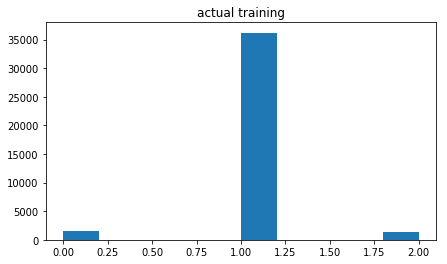

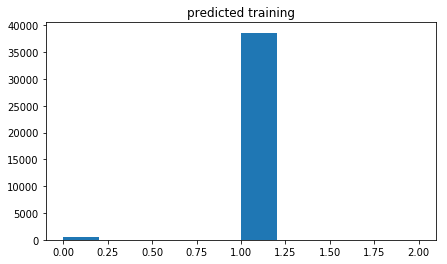

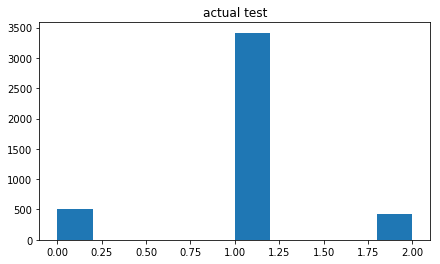

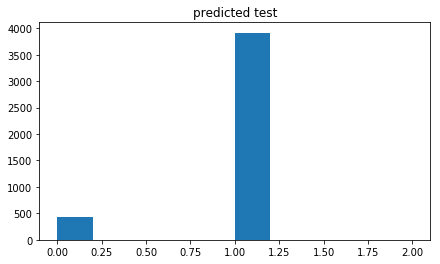

In [144]:
sklearn_experiment(LogisticRegression(solver='lbfgs', max_iter=200, multi_class='multinomial'))

training
              precision    recall  f1-score   support

         buy       0.88      0.05      0.10      1541
        hold       0.93      1.00      0.96     36192
        sell       0.00      0.00      0.00      1399

   micro avg       0.93      0.93      0.93     39132
   macro avg       0.60      0.35      0.35     39132
weighted avg       0.89      0.93      0.89     39132




testing
              precision    recall  f1-score   support

         buy       0.88      0.42      0.57       502
        hold       0.83      0.99      0.90      3415
        sell       0.00      0.00      0.00       430

   micro avg       0.83      0.83      0.83      4347
   macro avg       0.57      0.47      0.49      4347
weighted avg       0.75      0.83      0.77      4347



C:\Users\yerla\.conda\envs\ml\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


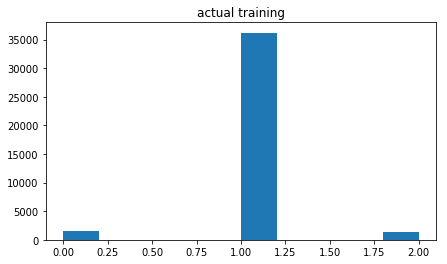

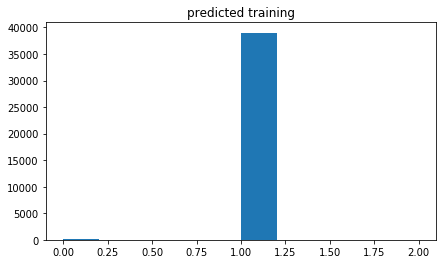

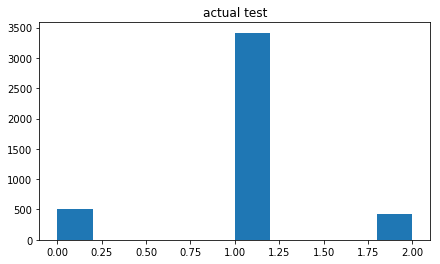

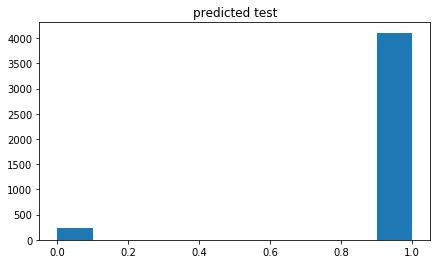

In [145]:
sklearn_experiment(SGDClassifier(max_iter=1000, tol=1e-3))

## Ensemble Models

In [89]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

training
              precision    recall  f1-score   support

         buy       1.00      1.00      1.00      1541
        hold       1.00      1.00      1.00     36192
        sell       1.00      1.00      1.00      1399

   micro avg       1.00      1.00      1.00     39132
   macro avg       1.00      1.00      1.00     39132
weighted avg       1.00      1.00      1.00     39132




testing
              precision    recall  f1-score   support

         buy       0.55      0.02      0.04       502
        hold       0.83      0.94      0.89      3415
        sell       0.23      0.24      0.23       430

   micro avg       0.77      0.77      0.77      4347
   macro avg       0.54      0.40      0.39      4347
weighted avg       0.74      0.77      0.72      4347



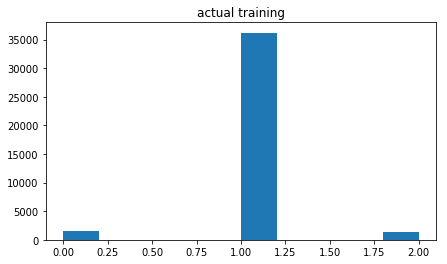

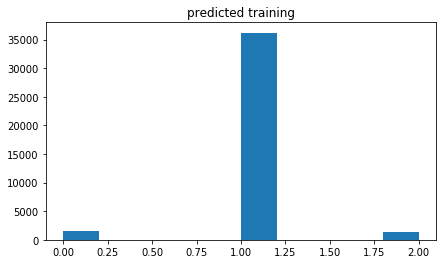

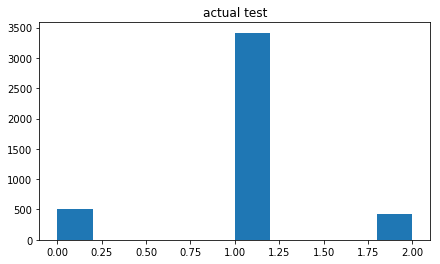

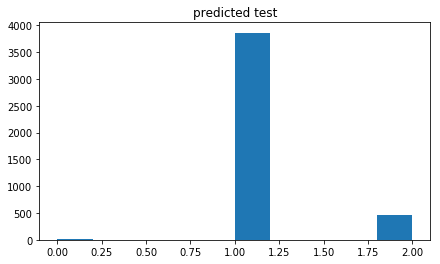

In [146]:
sklearn_experiment(RandomForestClassifier(n_estimators=200))

training
              precision    recall  f1-score   support

         buy       0.50      0.11      0.18      1541
        hold       0.93      0.99      0.96     36192
        sell       0.13      0.01      0.01      1399

   micro avg       0.92      0.92      0.92     39132
   macro avg       0.52      0.37      0.38     39132
weighted avg       0.88      0.92      0.90     39132




testing
              precision    recall  f1-score   support

         buy       0.33      0.01      0.02       502
        hold       0.91      0.54      0.68      3415
        sell       0.15      0.78      0.25       430

   micro avg       0.50      0.50      0.50      4347
   macro avg       0.46      0.44      0.32      4347
weighted avg       0.77      0.50      0.56      4347



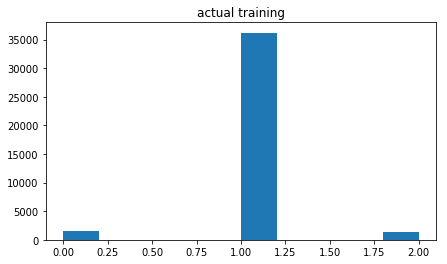

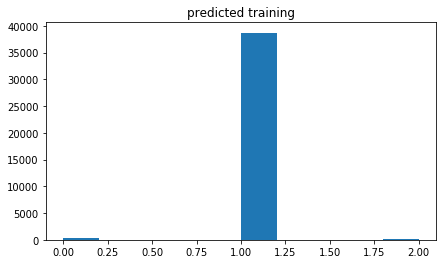

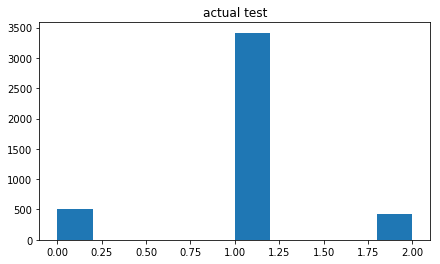

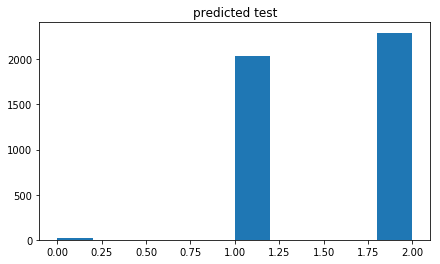

In [147]:
sklearn_experiment(AdaBoostClassifier(n_estimators=150))

training
              precision    recall  f1-score   support

         buy       0.93      0.32      0.47      1541
        hold       0.94      1.00      0.97     36192
        sell       0.94      0.02      0.04      1399

   micro avg       0.94      0.94      0.94     39132
   macro avg       0.94      0.45      0.49     39132
weighted avg       0.94      0.94      0.91     39132




testing
              precision    recall  f1-score   support

         buy       1.00      0.01      0.03       502
        hold       0.95      0.19      0.32      3415
        sell       0.11      0.95      0.20       430

   micro avg       0.25      0.25      0.25      4347
   macro avg       0.69      0.39      0.18      4347
weighted avg       0.87      0.25      0.27      4347



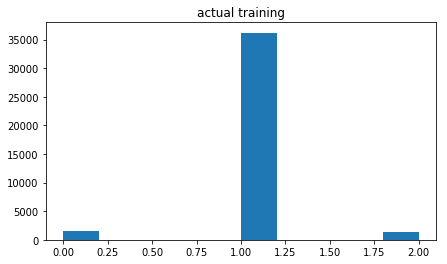

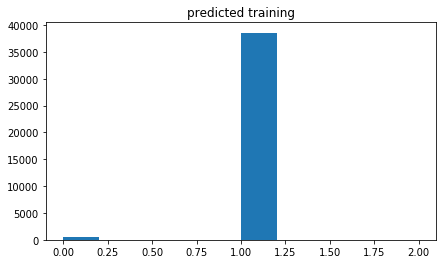

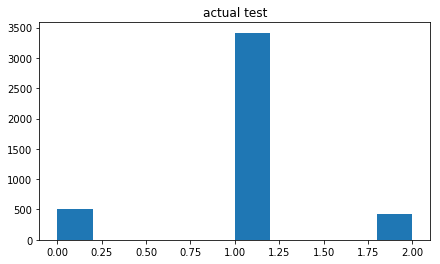

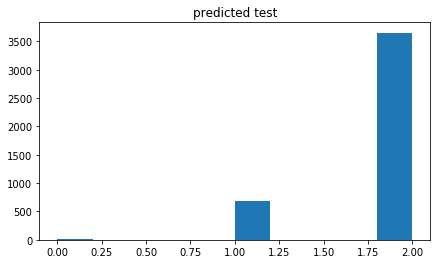

In [149]:
sklearn_experiment(GradientBoostingClassifier(n_estimators=150))